<i><b>Public-AI</b></i>

# 은닉층 시각화하기


### _Objective_

* Convolution Layer에서 입력을 어떻게 변형시키는지 이해하기 위해 은닉층을 시각화해보도록 하겠습니다. <br>

In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
from zipfile import ZipFile

import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

## Dataset) Cat VS Dog Dataset

개와 고양이를 분류하기 위해, 아래와 같이 데이터셋을 준비하였습니다.<Br> 

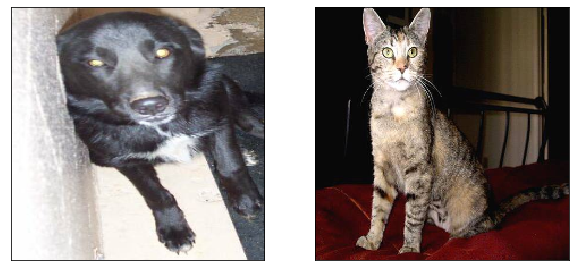

In [2]:
data_dir = "cat-vs-dog"
fpath = get_file("cat-vs-dog.zip", 
                 "https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cat-vs-dog.zip")

if not os.path.exists(data_dir):
    with ZipFile(fpath,'r') as f:
        f.extractall(data_dir)
        
# 이미지 시각화하기 
dog_image = cv2.imread(
    os.path.join(data_dir,'train','dog','dog.10000.jpg'))
dog_image = cv2.cvtColor(dog_image, cv2.COLOR_BGR2RGB)
dog_image = cv2.resize(dog_image, (224,224))

cat_image = cv2.imread(
    os.path.join(data_dir,'train','cat','cat.10000.jpg'))
cat_image = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB)
cat_image = cv2.resize(cat_image, (224,224))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(dog_image)
ax = fig.add_subplot(1,2,2)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(cat_image)
plt.show()        

<br><br>

# \[ 은닉층 시각화  \]
---

* 딥러닝 모델을 블랙 박스 모델이라고 설명하는 사람들이 많습니다. 어떻게 추론하는 지 그 과정을 해석하기가 매우 어렵기 때문입니다.* <br>
* 하지만 Convolution Layer에서는 어떠한 특징을 위주로 뽑아냈는지를 은닉층의 활성화정도를 통해 쉽게 확인할 수 있습니다.

<br>

## 1. Pretrained Model 가져오기

이번에도 VGG Network를 가져오도록 하겠습니다.

### (1) VGG 모델 가져오기

In [ ]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16()

vgg16.summary()

 38543360/553467096 [=>............................] - ETA: 1:17:32

### (2) 은닉층 출력값 가져오기

우리는 `block1_conv1`부터 `block5_conv3`까지 각층에서 어떤 출력값을 반환하고 있는지를 보도록 하겠습니다. Keras API를 활용하면 각층의 출력값을 좀더 간단하게 가져올 수 있습니다.<br>
`model.summary`에 적힌 이름을 통해, Tensor을 가져올 수 있습니다.

In [ ]:
# 입력 텐서 가져오기
inputs = vgg16.input

# 은닉층 텐서 가져오기
conv1_1 = vgg16.get_layer('block1_conv1').output
conv1_2 = vgg16.get_layer('block1_conv2').output

conv2_1 = vgg16.get_layer('block2_conv1').output
conv2_2 = vgg16.get_layer('block2_conv2').output

conv3_3 = vgg16.get_layer('block3_conv3').output
conv4_3 = vgg16.get_layer('block4_conv3').output

conv5_3 = vgg16.get_layer('block5_conv3').output

<br>

## 2. 은닉층 별 결과 시각화하기

* 위에서 가져온 7개의 은닉층의 결과를 시각화 해보도록 하겠습니다.

### (1) Block-1 층 시각화하기

In [ ]:
from tensorflow.keras.models import Model

model = Model(vgg16.input, 
              vgg16.get_layer('block1_conv1').output)

In [ ]:
prep_image = dog_image.astype(np.float32) - [123.68,116.779,103.939,]

hidden_outputs = model.predict(prep_image[None])[0]

# (height,width,channel) -> (channel, height, width)
hidden_outputs = hidden_outputs.transpose(2,0,1) 

In [ ]:
fig = plt.figure(figsize=(12,12))

num_filters = len(hidden_outputs)
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters/rows))

for idx, hidden in enumerate(hidden_outputs,1):
    ax = fig.add_subplot(rows,cols,idx)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    ax.imshow(hidden)
plt.show()

첫번째 은닉층에서는 주요한 이미지 특성인 Edge와 Color을 위주로 활성화 함을 알 수 있습니다.<br>
특히 개의 몸통 부분에 대한 Edge가 많이 잡혔고, 두 눈에 대해서도 강하게 반응하는 것들이 나타납니다.

### (2) Block-2 층 시각화하기

In [ ]:
from tensorflow.keras.models import Model

model = Model(vgg16.input, 
              vgg16.get_layer('block2_conv2').output)

In [ ]:
prep_image = dog_image.astype(np.float32) - [123.68,116.779,103.939,]

hidden_outputs = model.predict(prep_image[None])[0]

# (height,width,channel) -> (channel, height, width)
hidden_outputs = hidden_outputs.transpose(2,0,1) 

In [ ]:
fig = plt.figure(figsize=(12,12))

num_filters = len(hidden_outputs)
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters/rows))

for idx, hidden in enumerate(hidden_outputs,1):
    ax = fig.add_subplot(rows,cols,idx)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    ax.imshow(hidden)
plt.show()

단순한 선과 색이 아니라, 이제는 주름, 곡선 같은 조금 더 복잡한 특성들에 반응하기 시작합니다.<br>
Convolution Layer를 4층 정도 지나가면서, 좀 더 넓은 범위의 특성들에 반응하기 때문입니다

### (3) Block-3 층 시각화하기

In [ ]:
from tensorflow.keras.models import Model

model = Model(vgg16.input, 
              vgg16.get_layer('block3_conv3').output)

In [ ]:
prep_image = dog_image.astype(np.float32) - [123.68,116.779,103.939,]

hidden_outputs = model.predict(prep_image[None])[0]

# (height,width,channel) -> (channel, height, width)
hidden_outputs = hidden_outputs.transpose(2,0,1) 

In [ ]:
fig = plt.figure(figsize=(12,12))

num_filters = len(hidden_outputs)
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters/rows))

for idx, hidden in enumerate(hidden_outputs,1):
    ax = fig.add_subplot(rows,cols,idx)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    ax.imshow(hidden)
plt.show()

상위 층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워집니다. <br>
'강아지의 털', '강아지의 다리' 처럼 고수준 개념을 인코딩하기 시작합니다.<br>
상위 층의 표현에 가면 갈수록 은닉층에서는 국소적으로 강한 특성을 나타내는 곳이 생기고, 전반적으로는 활성화 정도가 작아집니다.

### (4) Block-4 층 시각화하기

In [ ]:
from tensorflow.keras.models import Model

model = Model(vgg16.input, 
              vgg16.get_layer('block4_conv3').output)

In [ ]:
prep_image = dog_image.astype(np.float32) - [123.68,116.779,103.939,]

hidden_outputs = model.predict(prep_image[None])[0]

# (height,width,channel) -> (channel, height, width)
hidden_outputs = hidden_outputs.transpose(2,0,1) 

In [ ]:
fig = plt.figure(figsize=(12,12))

num_filters = len(hidden_outputs)
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters/rows))

for idx, hidden in enumerate(hidden_outputs,1):
    ax = fig.add_subplot(rows,cols,idx)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    ax.imshow(hidden)
plt.show()

은닉층 내에서 특정 위치 별로 활성화가 뚜렷하게 발생하고 그 이외의 지점에서는 거의 활성화되지 않은 것을 볼 수 있습니다.<br>
높은 층의 활성화는 특정 입력에 관한 시각적 정보가 점점 줄어들고 타깃에 관한 정보가 점점 더 증가합니다.<br>

### (5) Block-5 층 시각화하기

In [ ]:
from tensorflow.keras.models import Model

model = Model(vgg16.input, 
              vgg16.get_layer('block5_conv3').output)

In [ ]:
prep_image = dog_image.astype(np.float32) - [123.68,116.779,103.939,]

hidden_outputs = model.predict(prep_image[None])[0]

# (height,width,channel) -> (channel, height, width)
hidden_outputs = hidden_outputs.transpose(2,0,1) 

In [ ]:
fig = plt.figure(figsize=(12,12))

num_filters = len(hidden_outputs)
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters/rows))

for idx, hidden in enumerate(hidden_outputs,1):
    ax = fig.add_subplot(rows,cols,idx)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    ax.imshow(hidden)
plt.show()

최종적으로 나온 이 정보를 바탕으로 모델은 이미지를 분류하게 됩니다.<br>
이후 배울 Object Detection에서는 이렇게 고차원으로 인코딩된 정보에서 <br>
사물의 위치를 찾게 됩니다.

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/15

---